In [2]:
import torch

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from torch import nn, optim

import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

Предсказание погоды на следующий день: 
Будет дождь, если rainfall >=1

In [3]:
df = pd.read_csv('weatherAUS.csv')
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [4]:
df.shape

(145460, 23)

Удалим столбцы

In [5]:
cols = ['Rainfall', 'Humidity3pm', 'Pressure9am', 'RainToday', 'RainTomorrow']

df = df[cols]

Удаление строк с пропущенными значениями

In [6]:
df = df.dropna()
df.head()

,Rainfall,Humidity3pm,Pressure9am,RainToday,RainTomorrow
0,0.6,22.0,1007.7,No,No
1,0.0,25.0,1010.6,No,No
2,0.0,30.0,1007.6,No,No
3,0.0,16.0,1017.6,No,No
4,1.0,33.0,1010.8,No,No


Преобразование данных стобца

In [7]:
df['RainToday'].replace({'No': 0, 'Yes': 1}, inplace = True)
df['RainTomorrow'].replace({'No': 0, 'Yes': 1}, inplace = True)

/tmp/ipykernel_16775/3734455367.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['RainToday'].replace({'No': 0, 'Yes': 1}, inplace = True)
/tmp/ipykernel_16775/3734455367.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['RainToday'].replace({'No': 0, 'Yes': 1}, inplace = True)
/tmp/ipyke

In [8]:
df[df['RainTomorrow']==0.0].count()

Rainfall        97103
Humidity3pm     97103
Pressure9am     97103
RainToday       97103
RainTomorrow    97103
dtype: int64

In [9]:
df[df['RainTomorrow']==1.0].count()

Rainfall        27586
Humidity3pm     27586
Pressure9am     27586
RainToday       27586
RainTomorrow    27586
dtype: int64

Классы несбалансированы

In [10]:
X = df[['Rainfall', 'Humidity3pm', 'RainToday', 'Pressure9am']]
y = df[['RainTomorrow']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

Преобразуем в тензор

In [11]:
X_train = torch.from_numpy(X_train.to_numpy()).float()
y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())

X_test = torch.from_numpy(X_test.to_numpy()).float()
y_test = torch.squeeze(torch.from_numpy(y_test.to_numpy()).float())

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([99751, 4]) torch.Size([99751])
torch.Size([24938, 4]) torch.Size([24938])


#NN

In [12]:

class Net(nn.Module):

  def __init__(self, n_features):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(n_features, 8)
    self.fc2 = nn.Linear(8, 4)
    self.fc3 = nn.Linear(4, 1)
    
    # torch.nn.init.xavier_uniform_(self.fc1.weight) 

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    return torch.sigmoid(self.fc3(x))

## Binary Cross Entropy Loss
Эта функция потерь используется, когда модель возвращает вероятности для двух классов

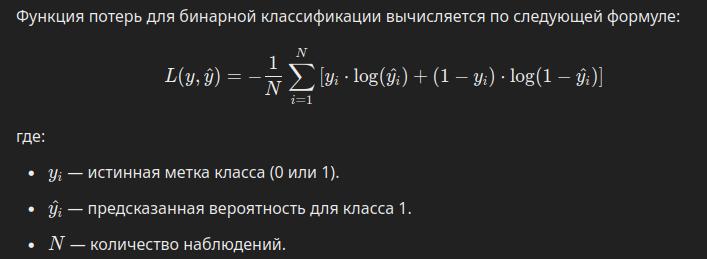

In [13]:
criterion = nn.BCELoss()
device = torch.device("cpu") 

# Перемещение данных на устройство
X_train = X_train.to(device)
y_train = y_train.to(device)

X_test = X_test.to(device)
y_test = y_test.to(device)

In [14]:
def calculate_accuracy(y_true, y_pred):
  predicted = y_pred.ge(.5).view(-1)
  return (y_true == predicted).sum().float() / len(y_true)

In [15]:
net = Net(4)  # Создание модели с 4 входами
optimizer = optim.Adam(net.parameters(), lr=0.0001)
net = net.to(device) # модель переносится на устройство

criterion = criterion.to(device)

for epoch in range(2000):

    train_loss = 0
    y_pred = net(X_train)
    
    y_pred = torch.squeeze(y_pred) # удаляет лишние размерности из предсказаний
    train_loss = criterion(y_pred, y_train) 
        
    optimizer.zero_grad() # Обнуляем градиенты

    train_loss.backward() 

    optimizer.step() # обновляем параметры модели

    if epoch % 100 == 0:

          y_test_pred = net(X_test)
          y_test_pred = torch.squeeze(y_test_pred)

          test_loss = criterion(y_test_pred, y_test)

          test_acc = calculate_accuracy(y_test, y_test_pred)
          print(
    f'''epoch {epoch}
    Test  set - loss: {test_loss}, accuracy: {test_acc}
    ''')

epoch 0
    Test  set - loss: 7.164628505706787, accuracy: 0.2216697335243225
    
epoch 100
    Test  set - loss: 0.5720734596252441, accuracy: 0.7959740161895752
    
epoch 200
    Test  set - loss: 0.5436038970947266, accuracy: 0.7788916230201721
    
epoch 300
    Test  set - loss: 0.5333544611930847, accuracy: 0.7793327569961548
    
epoch 400
    Test  set - loss: 0.5154785513877869, accuracy: 0.7796936631202698
    
epoch 500
    Test  set - loss: 0.4807439148426056, accuracy: 0.7794530391693115
    
epoch 600
    Test  set - loss: 0.46781331300735474, accuracy: 0.7808966040611267
    
epoch 700
    Test  set - loss: 0.4557620584964752, accuracy: 0.784866452217102
    
epoch 800
    Test  set - loss: 0.4444303512573242, accuracy: 0.7911219596862793
    
epoch 900
    Test  set - loss: 0.4336303770542145, accuracy: 0.7985804677009583
    
epoch 1000
    Test  set - loss: 0.4241870939731598, accuracy: 0.8103296160697937
    
epoch 1100
    Test  set - loss: 0.41714736819267273, ac

In [19]:
MODEL_PATH = './model.pth'
torch.save(net, MODEL_PATH) # сохранения объекта PyTorch в файл


In [22]:
net = torch.load(MODEL_PATH, weights_only=False)
# 2й аргумент отключает безопасную загрузку и 
# позволяет загружать всю модель вместе с её классами и функциями.

In [19]:
classes = ['No rain', 'Raining']

y_pred = net(X_test)

y_pred = y_pred.ge(.5).view(-1).cpu()
y_test = y_test.cpu()

print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

     No rain       0.85      0.96      0.90     19413
     Raining       0.74      0.40      0.52      5525

    accuracy                           0.84     24938
   macro avg       0.79      0.68      0.71     24938
weighted avg       0.82      0.84      0.82     24938



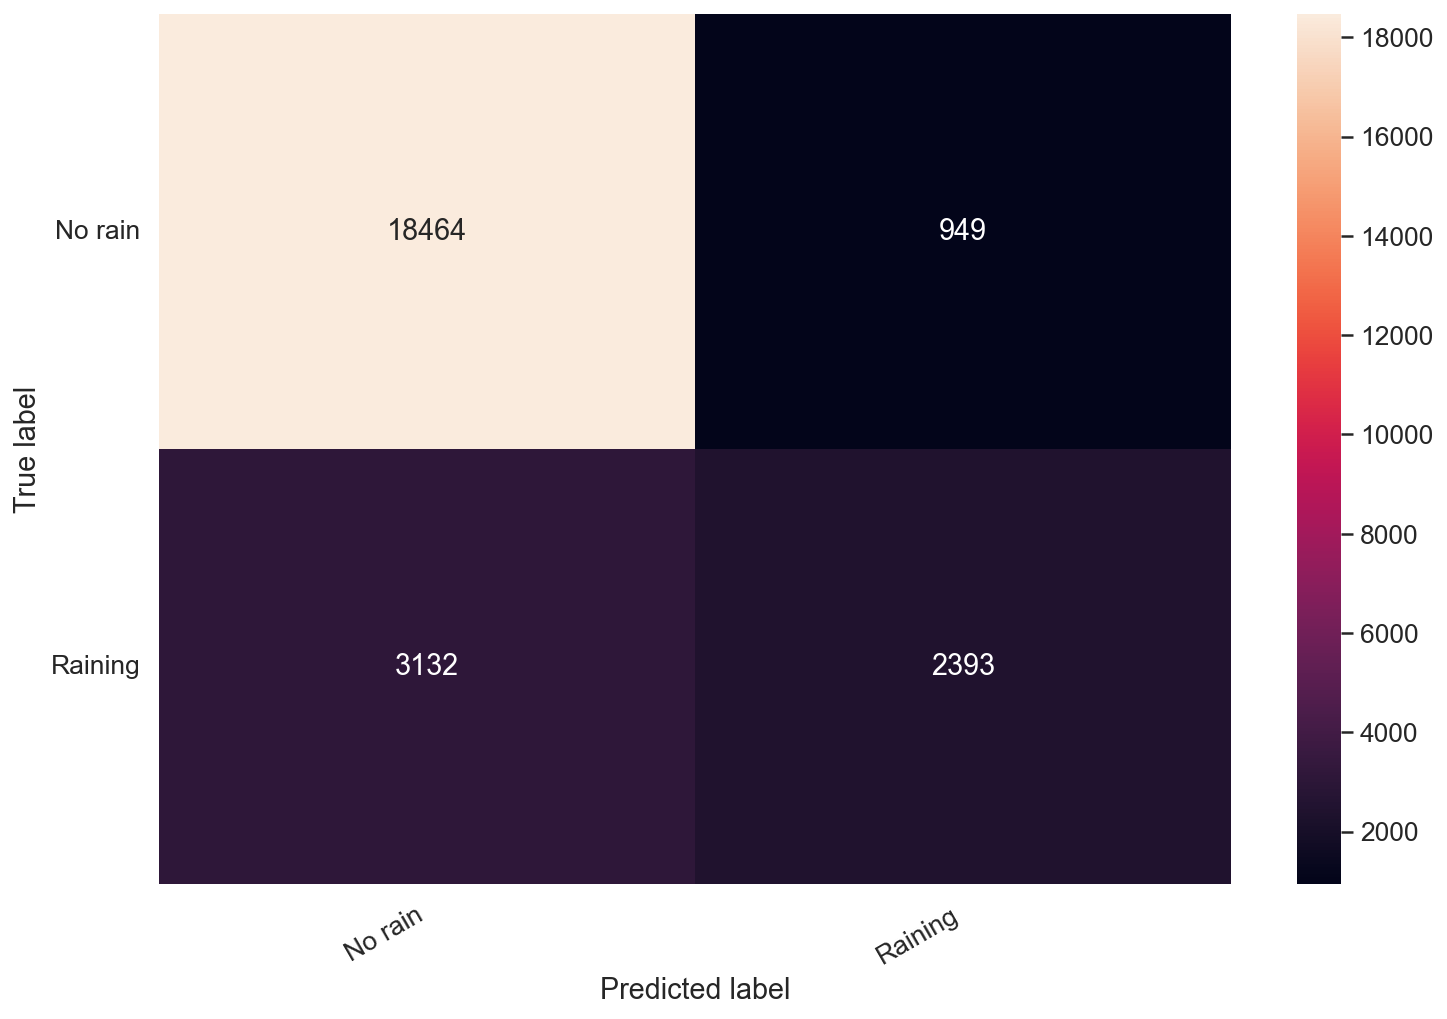

In [34]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)

hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

In [1]:
# 1. Проведите эксперименты, постройте график скорости cходимости сети в зависимости от learning_rate, 
# выберите оптимальное значение.

# 2. Примените нормализацию данных. Исследуйте скорость сходимости.

# 3. Измените струтуру сети. Постройте график/таблицу зависимости качества обучения в зависимости от удаления/добавления
# скрытого слоя, Удаления/добавления нейронов в каждом слое.

# 4. Исследуйте скорость сходимости сети в зависимости от выбранной функции активации в слоях.
# https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity

# 5. Исследуйте скорость сходимости сети в зависимости от выбранного метода оптимизации.
# https://pytorch.org/docs/stable/optim.html

# 6. Исследуйте скорость сходимости сети в зависимости от начальной инициализации весов.

In [56]:
learning_rates = [0.0001, 0.005, 0.01, 0.1]
results = {}
criterion = nn.MSELoss()

for lr in learning_rates:
    net = Net(4)
    optimizer = optim.Adam(net.parameters(), lr=lr)
    net = net.to(device)
    criterion = criterion.to(device)

    epoch_losses = []

    for epoch in range(200):
        y_pred = net(X_train)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y_train)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        epoch_losses.append(train_loss.item())

    results[lr] = epoch_losses

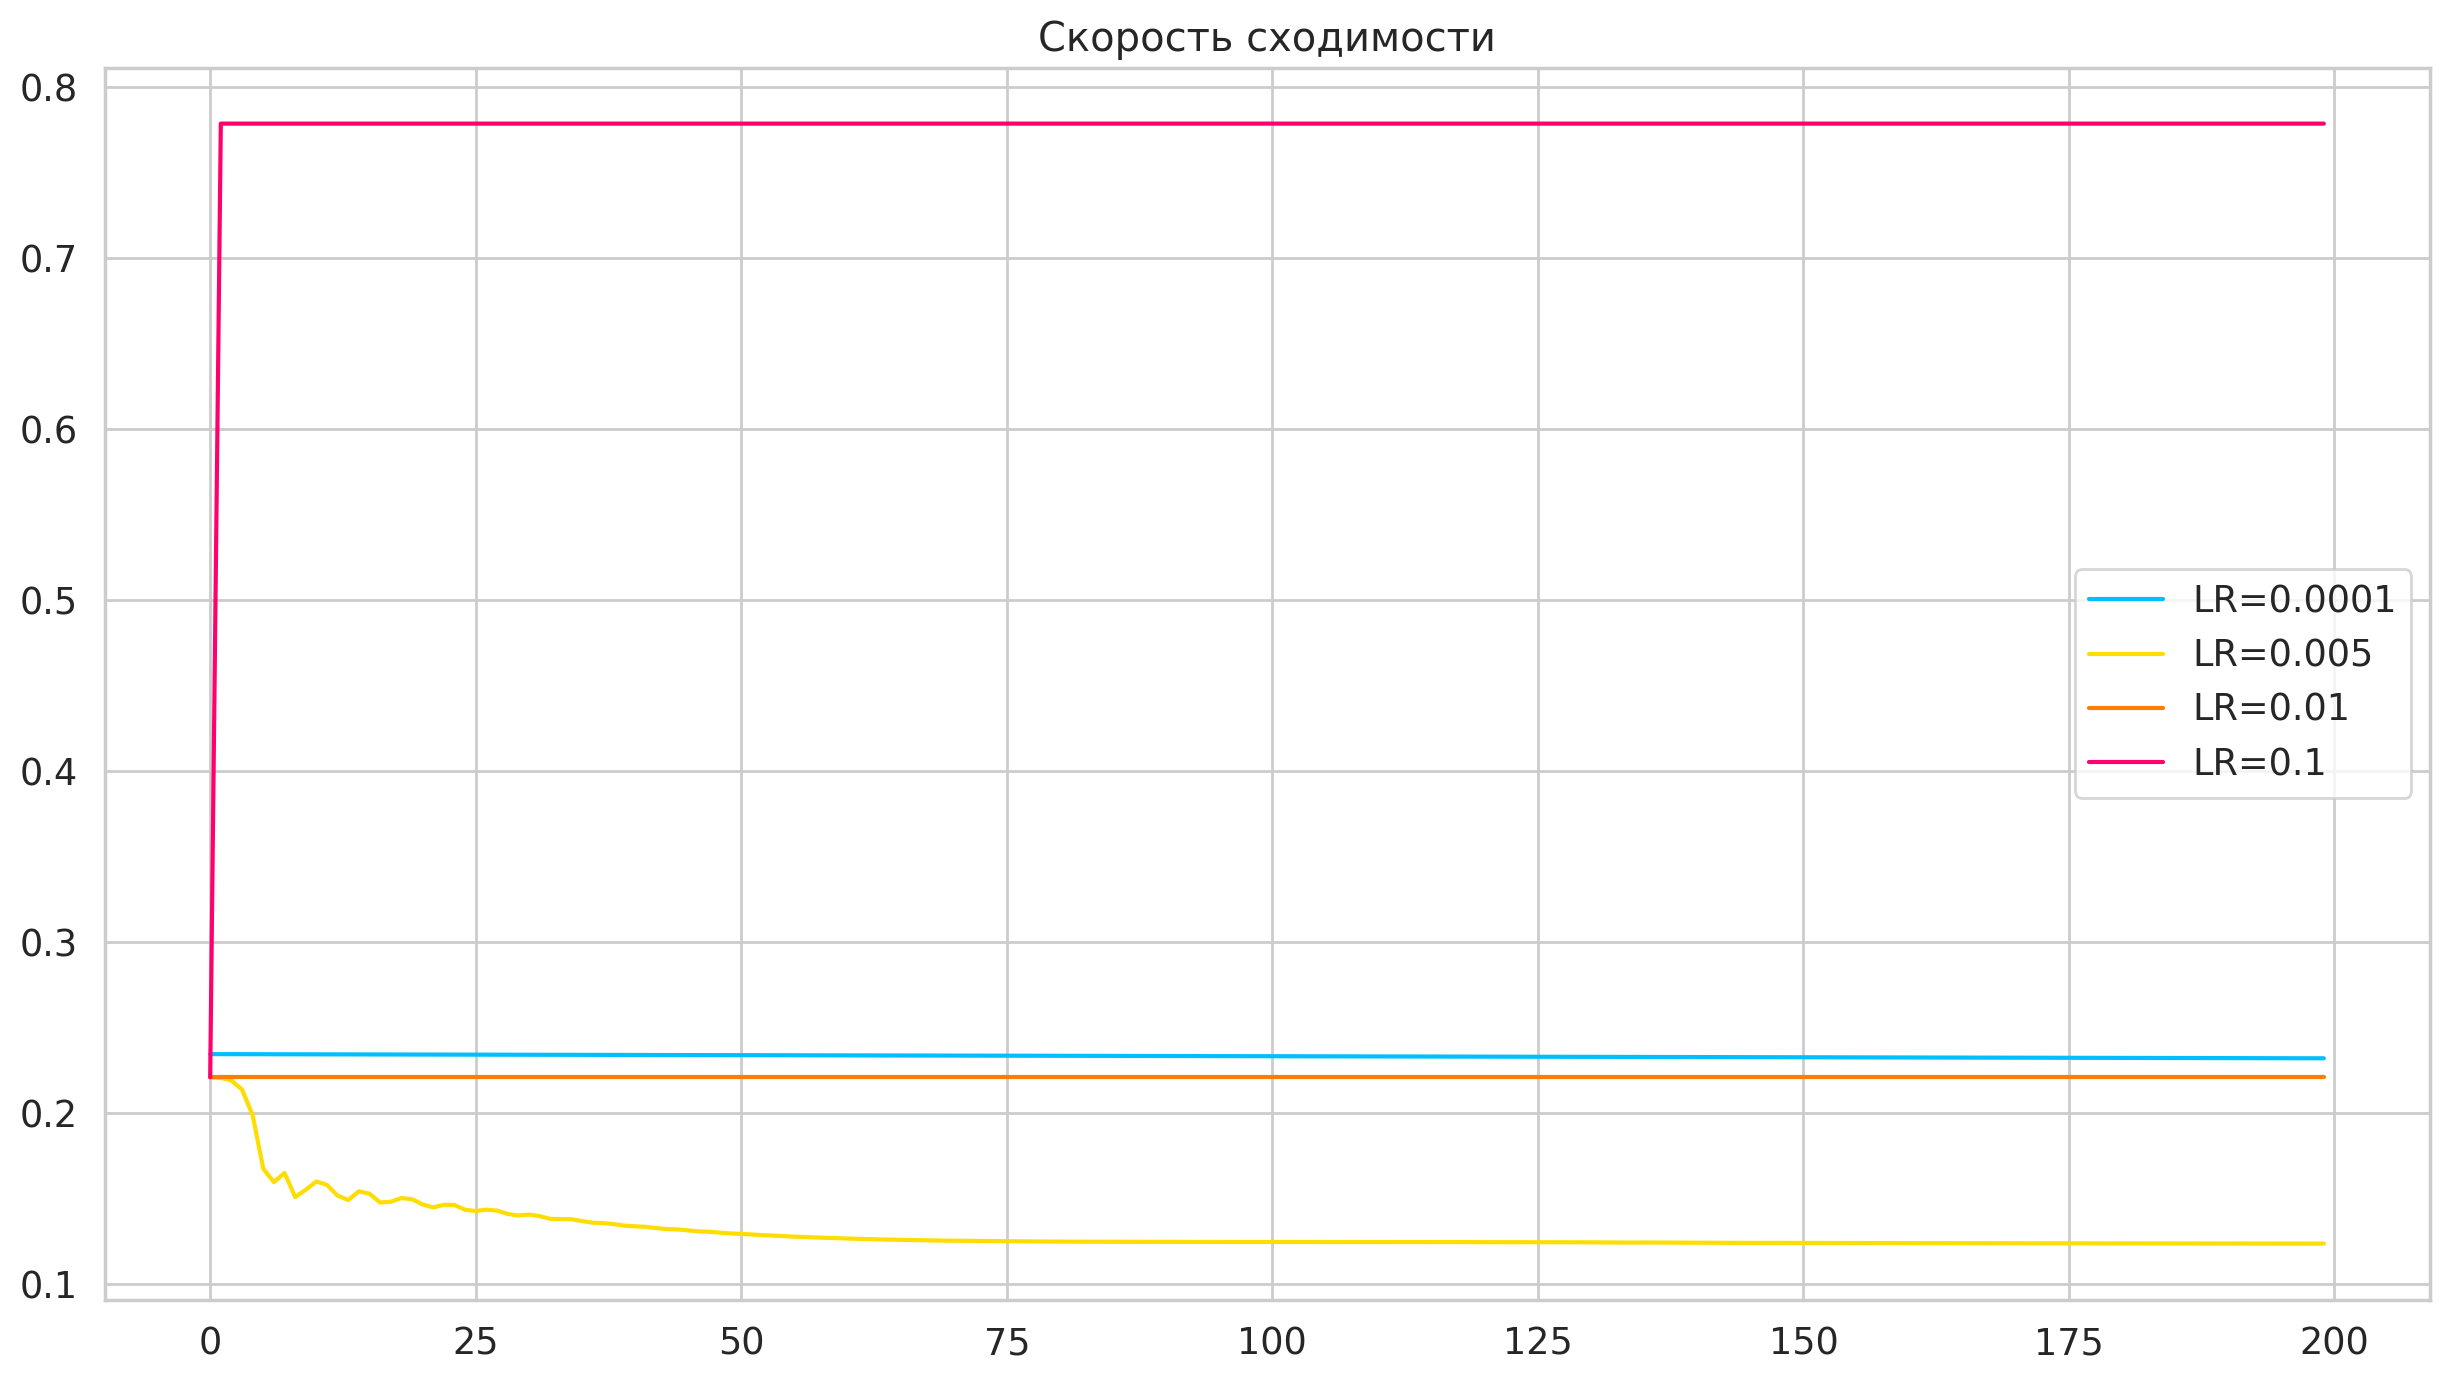

In [57]:
# Построим график
plt.figure(figsize=(15, 8))
for lr, loss in results.items():
    plt.plot(loss, label=f'LR={lr}')
plt.title('Скорость сходимости')
plt.legend()
plt.show()

In [64]:
results.items()
epo = [50, 75, 100, 125]
for epoch in epo:
    print("EPO: ", epoch)
    print("--------------------------")
    for lr in results.items():
        print(lr[0], lr[1][epoch])
    print("\n")

# Исходя из полученных данных оптимально будет взять lr = 0.005

EPO:  50
--------------------------
0.0001 0.23404601216316223
0.005 0.12957030534744263
0.01 0.22116069495677948
0.1 0.7788392901420593


EPO:  75
--------------------------
0.0001 0.23373745381832123
0.005 0.12522606551647186
0.01 0.22116069495677948
0.1 0.7788392901420593


EPO:  100
--------------------------
0.0001 0.23343026638031006
0.005 0.1247895359992981
0.01 0.22116069495677948
0.1 0.7788392901420593


EPO:  125
--------------------------
0.0001 0.23312421143054962
0.005 0.12469615042209625
0.01 0.22116069495677948
0.1 0.7788392901420593




In [65]:
# 2. Примените нормализацию данных. Исследуйте скорость сходимости.
from sklearn.preprocessing import StandardScaler

# Нормализация данных
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Преобразуем в тензоры после нормализации
X_train = torch.from_numpy(X_train).float()
X_test = torch.from_numpy(X_test).float()

In [66]:
for lr in learning_rates:
    net = Net(4)
    optimizer = optim.Adam(net.parameters(), lr=lr)
    net = net.to(device)
    criterion = criterion.to(device)

    epoch_losses = []

    for epoch in range(200):
        y_pred = net(X_train)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y_train)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        epoch_losses.append(train_loss.item())

    results[lr] = epoch_losses

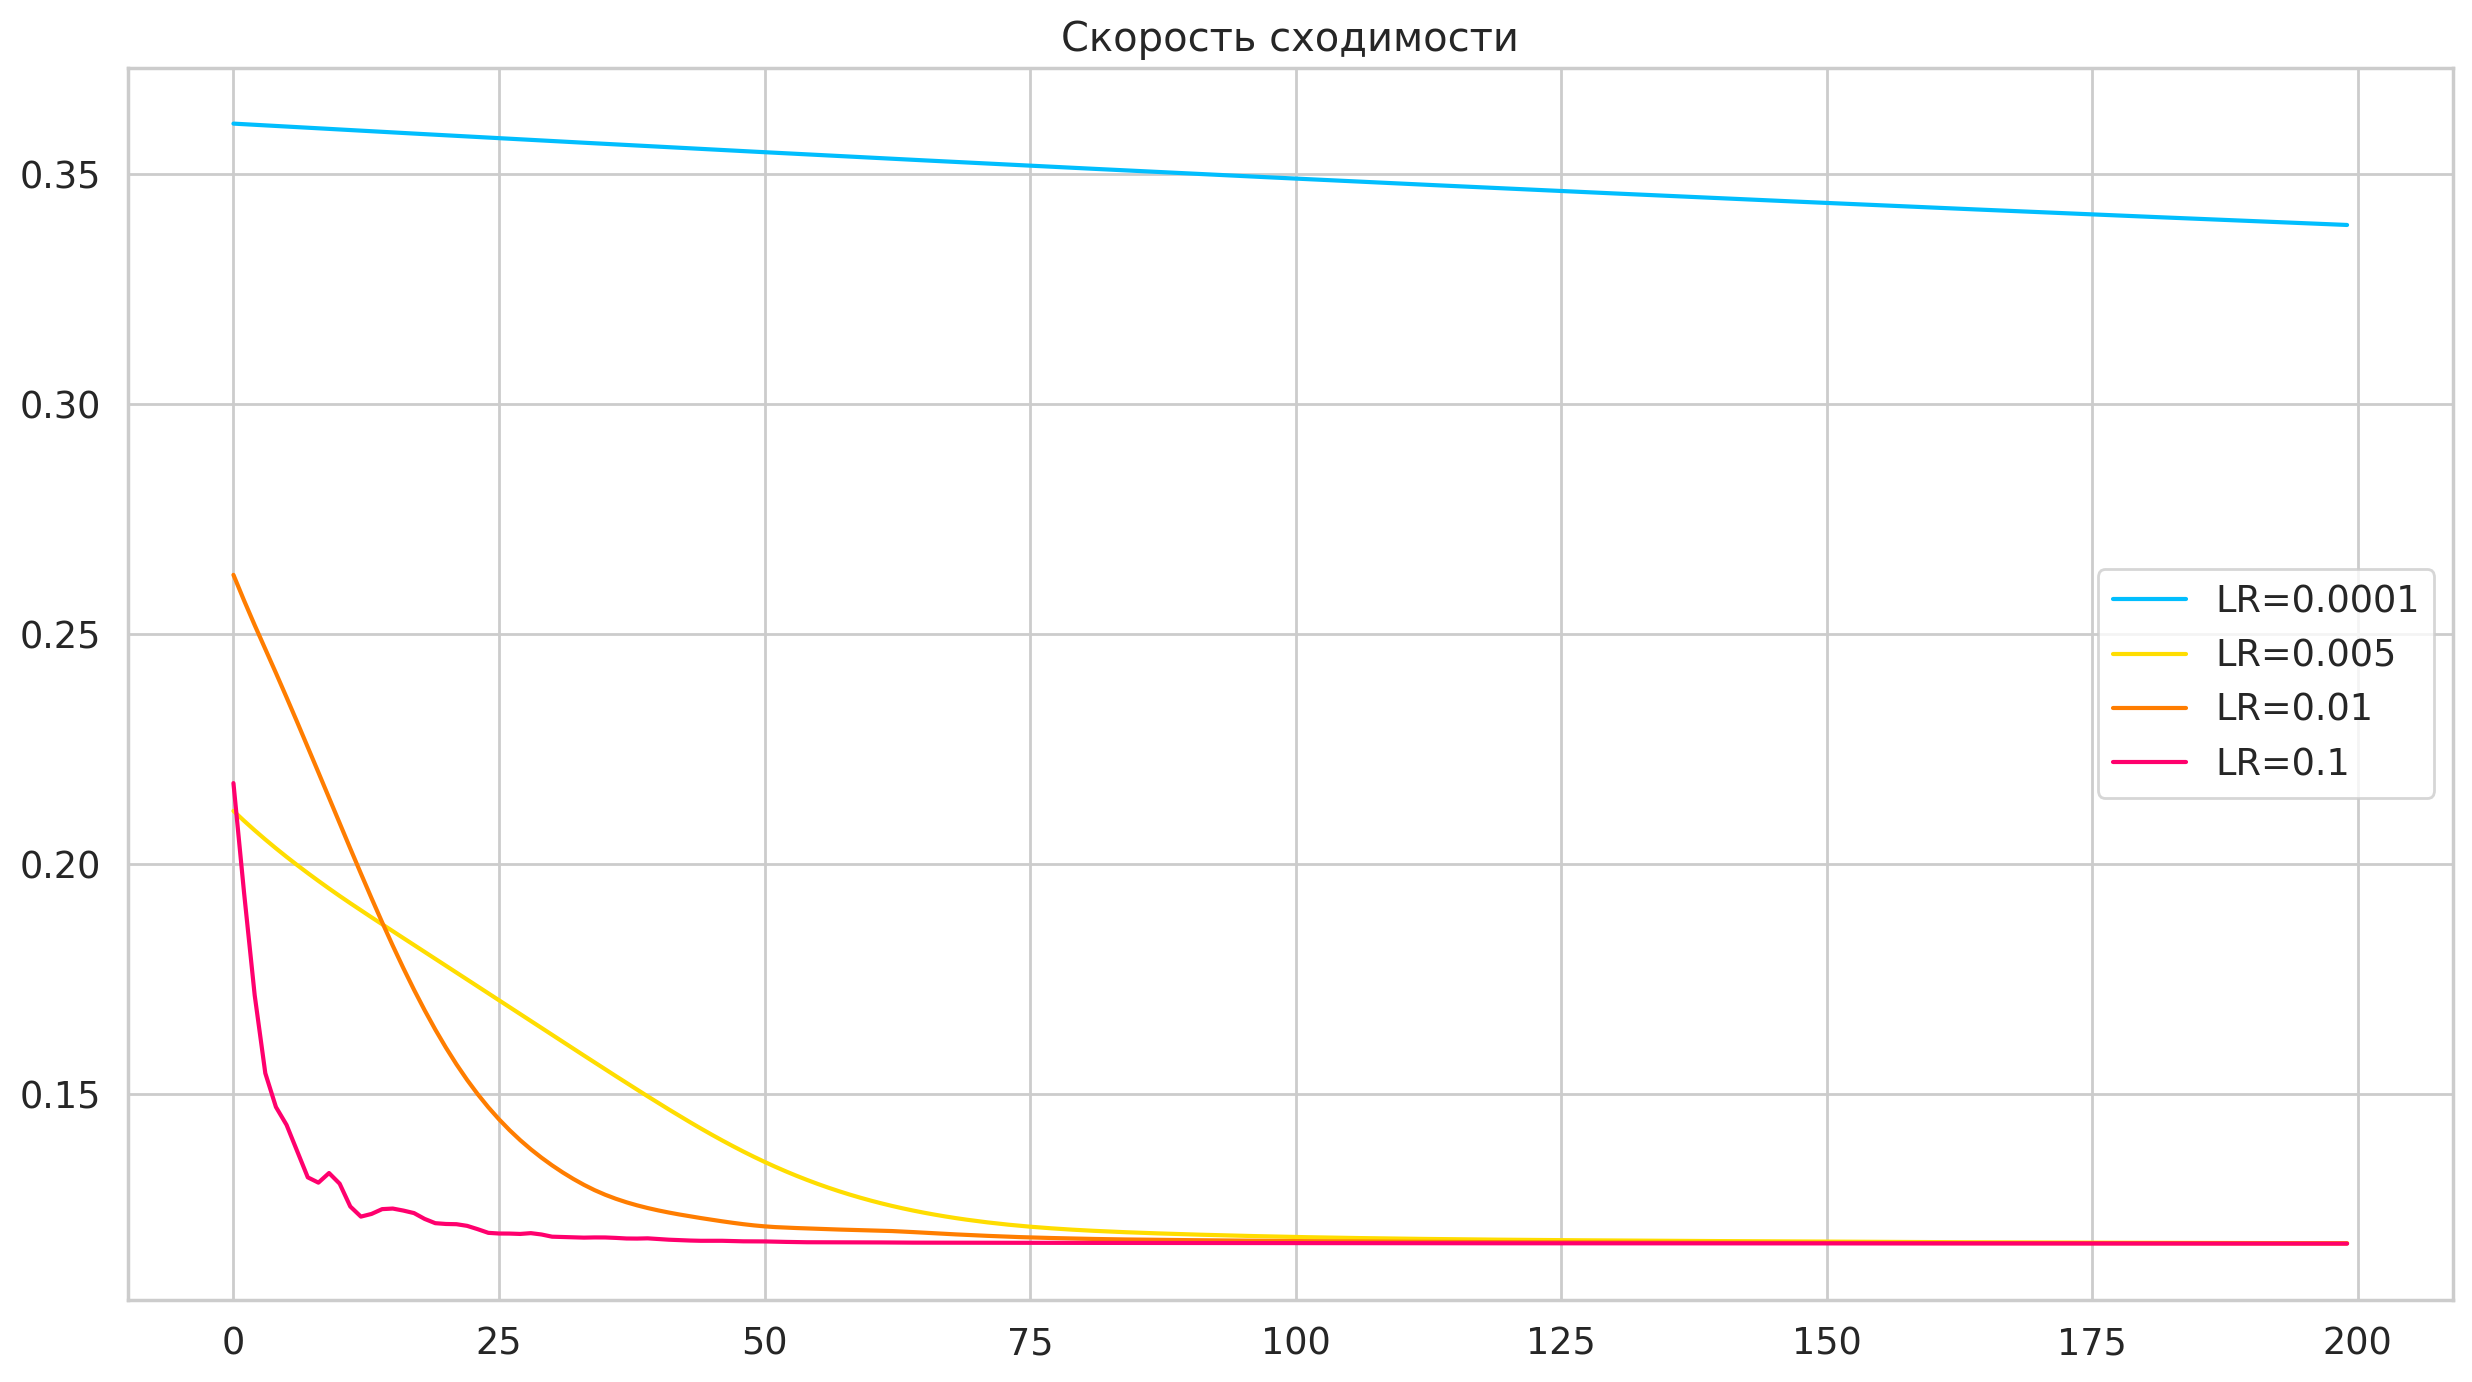

In [67]:
# Построим график
plt.figure(figsize=(15, 8))
for lr, loss in results.items():
    plt.plot(loss, label=f'LR={lr}')
plt.title('Скорость сходимости')
plt.legend()
plt.show()

In [69]:
# 3. Измените струтуру сети. 
# Постройте график/таблицу зависимости качества обучения в зависимости от удаления/добавления
# скрытого слоя
# Удаления/добавления нейронов в каждом слое.


class NV1(nn.Module):
    def __init__(self):
        super(NV1, self).__init__()
        self.fc1 = nn.Linear(4, 6)
        self.fc2 = nn.Linear(6, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class NV2(nn.Module):
    def __init__(self):
        super(NV2, self).__init__()
        self.fc1 = nn.Linear(4, 4)
        self.fc2 = nn.Linear(4, 4)
        self.fc3 = nn.Linear(4, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

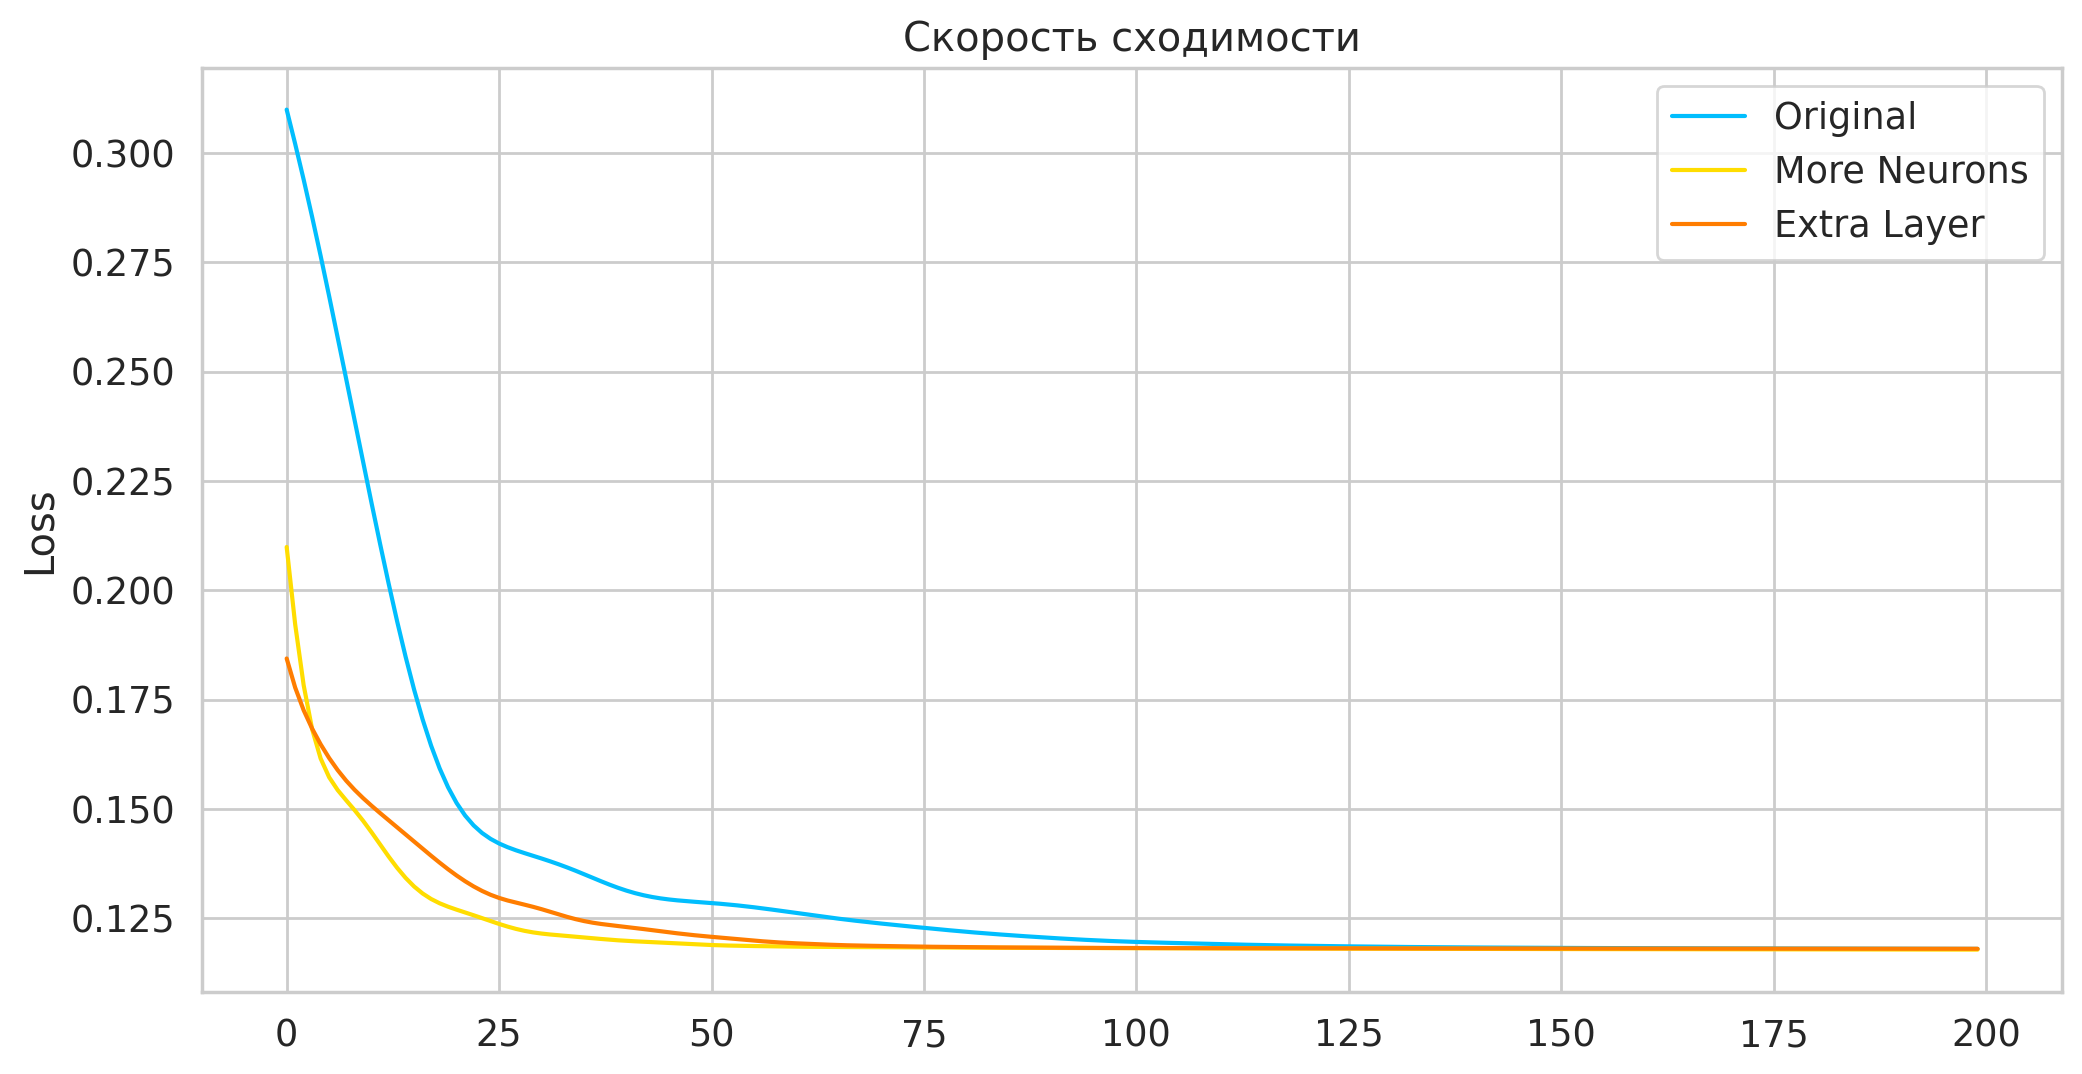

In [74]:
models = {
    "Original": Net(4),
    "More Neurons": NV1(),
    "Extra Layer": NV2()
}

results = {}

# Обучение и оценка каждой модели
for name, model in models.items():
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    criterion = criterion.to(device)

    epoch_losses = []

    for epoch in range(200):
        y_pred = model(X_train)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y_train)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        epoch_losses.append(train_loss.item())

    results[name] = epoch_losses


# Построение графиков
plt.figure(figsize=(12, 6))
for name, loss in results.items():
    plt.plot(loss, label=f"{name}")
plt.title("Скорость сходимости")
plt.ylabel('Loss')
plt.legend()
plt.show()

In [77]:
# 4. Исследуйте скорость сходимости сети в зависимости от выбранной функции активации в слоях.
# https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity


class NetReLU(nn.Module):
    def __init__(self):
        super(NetReLU, self).__init__()
        self.fc1 = nn.Linear(4, 4)
        self.fc2 = nn.Linear(4, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class NetTanh(nn.Module):
    def __init__(self):
        super(NetTanh, self).__init__()
        self.fc1 = nn.Linear(4, 4)
        self.fc2 = nn.Linear(4, 1)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = self.fc2(x)
        return x

class NetSigmoid(nn.Module):
    def __init__(self):
        super(NetSigmoid, self).__init__()
        self.fc1 = nn.Linear(4, 4)
        self.fc2 = nn.Linear(4, 1)

    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = self.fc2(x)
        return x

# import torch.nn.functional as F

activations = {
    "ReLU": NetReLU(),
    "Tanh": NetTanh(),
    "Sigmoid": NetSigmoid(),
}

In [81]:
results_activations = {}

# Обучение и оценка каждой модели
for name, model in activations.items():
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    criterion = criterion.to(device)

    epoch_losses = []

    for epoch in range(200):
        y_pred = model(X_train)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y_train)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        epoch_losses.append(train_loss.item())

    results_activations[name] = epoch_losses

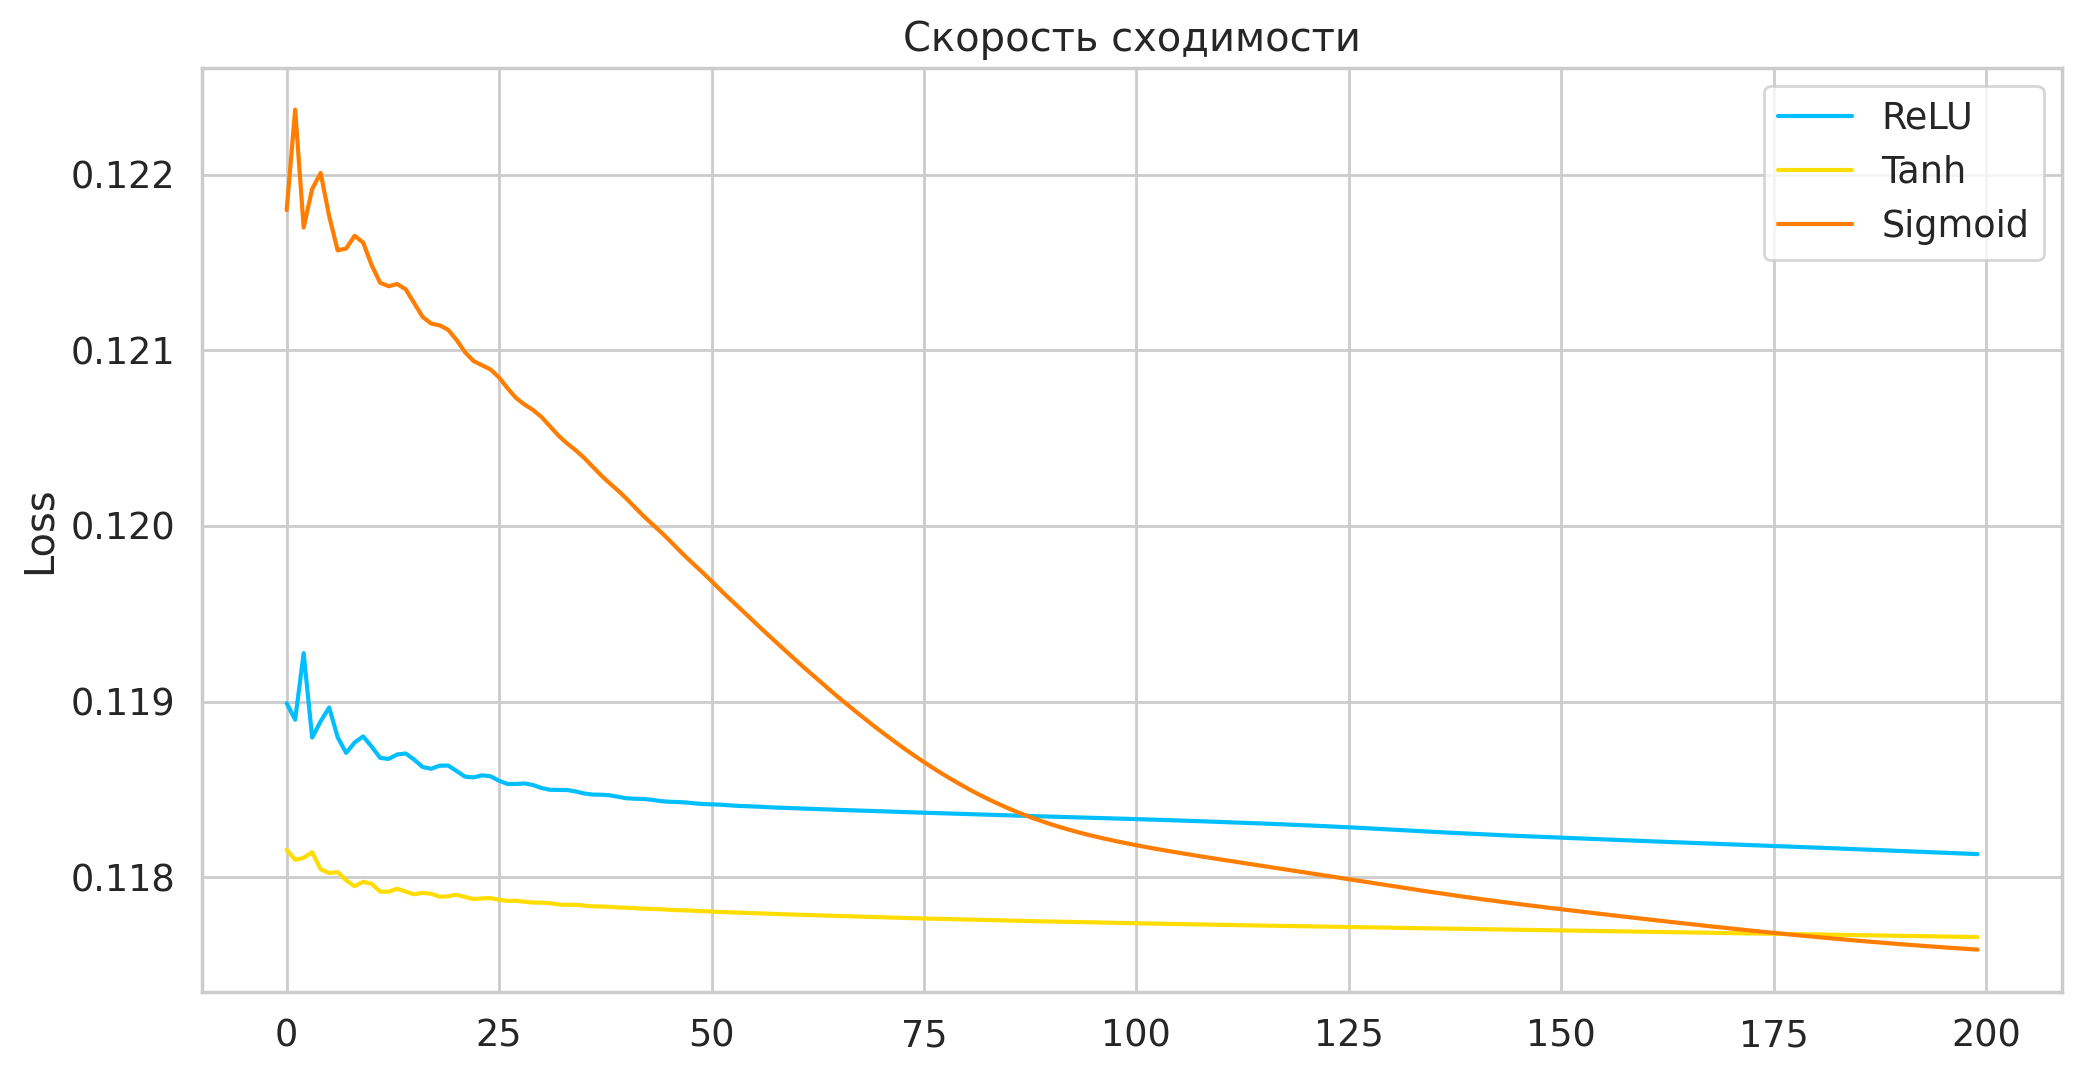

In [82]:
# Построение графиков
plt.figure(figsize=(12, 6))
for name, loss in results_activations.items():
    plt.plot(loss, label=f"{name}")
plt.title("Скорость сходимости")
plt.ylabel('Loss')
plt.legend()
plt.show()

### Это и прошлое задание дают ощутимо разные показатели от запуска к запуску.

In [83]:
# 5. Исследуйте скорость сходимости сети в зависимости от выбранного метода оптимизации.
# https://pytorch.org/docs/stable/optim.html

In [84]:
optimizers = {
    "SGD": lambda params: optim.SGD(params, lr=0.01),
    "Adam": lambda params: optim.Adam(params, lr=0.01),
    "RMSprop": lambda params: optim.RMSprop(params, lr=0.01)
}

In [85]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(4, 4)
        self.fc2 = nn.Linear(4, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [86]:
results_optimizers = {}

# Обучение и оценка каждой модели с разными оптимизаторами
for name, optimizer_func in optimizers.items():
    model = Net().to(device)
    optimizer = optimizer_func(model.parameters())
    criterion = criterion.to(device)

    epoch_losses = []

    for epoch in range(200):
        y_pred = model(X_train)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y_train)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        epoch_losses.append(train_loss.item())

    results_optimizers[name] = epoch_losses

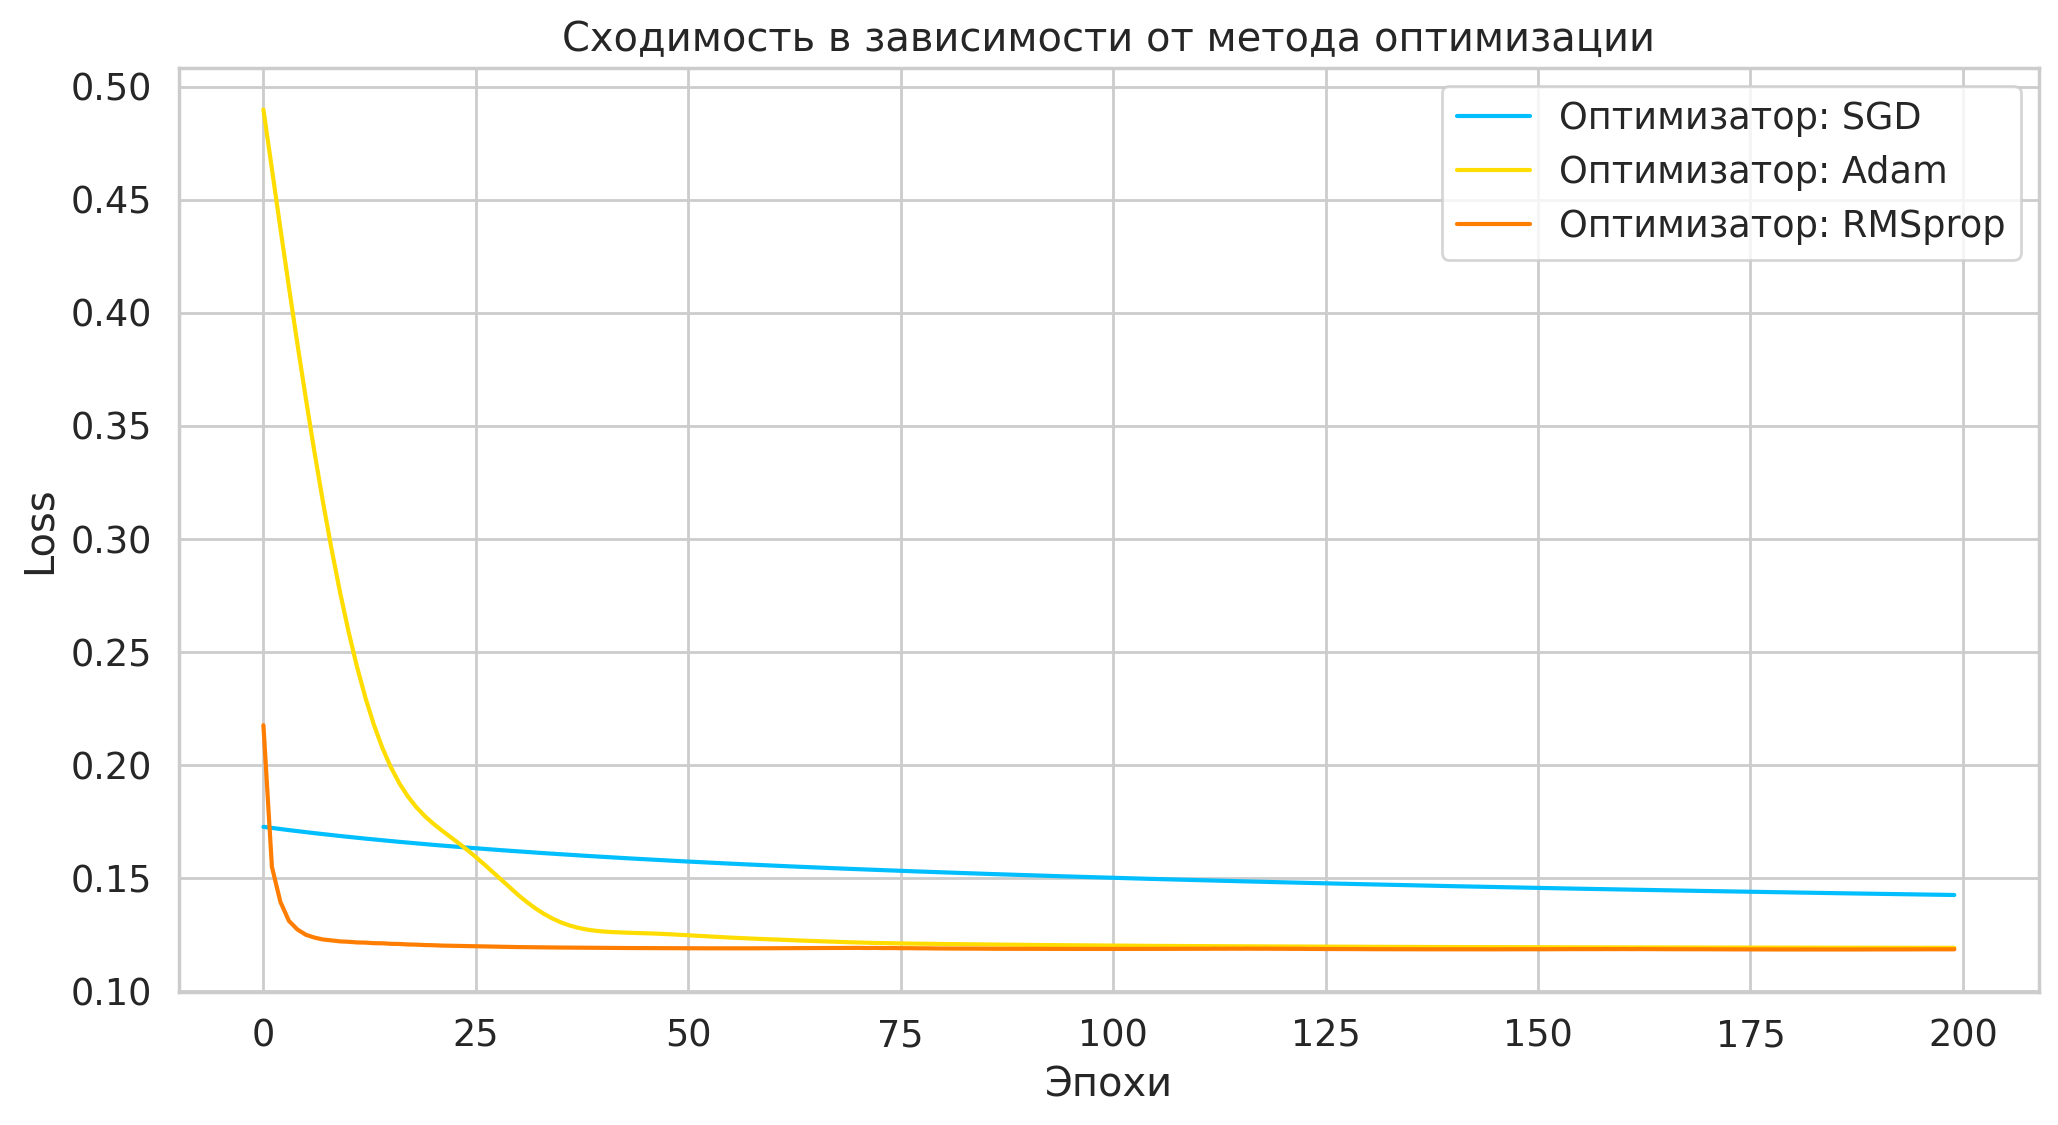

In [87]:
plt.figure(figsize=(12, 6))
for name, loss in results_optimizers.items():
    plt.plot(loss, label=f"Оптимизатор: {name}")
plt.title("Сходимость в зависимости от метода оптимизации")
plt.xlabel('Эпохи')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# 6. Исследуйте скорость сходимости сети в зависимости от начальной инициализации весов.

In [88]:
from torch.nn.init import xavier_uniform_, kaiming_uniform_, normal_

class Net(nn.Module):
    def __init__(self, init_func=None):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(4, 4)
        self.fc2 = nn.Linear(4, 1)

        # Инициализация весов, если функция передана
        if init_func:
            self.apply(init_func)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Определяем функции инициализации
def init_normal(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0.0, std=0.1)
        nn.init.constant_(m.bias, 0)

def init_xavier(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.constant_(m.bias, 0)

def init_kaiming(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        nn.init.constant_(m.bias, 0)


initializations = {
    "Normal": init_normal,
    "Xavier": init_xavier,
    "Kaiming": init_kaiming
}

In [99]:
results_initializations = {}

for name, init_func in initializations.items():
    model = Net(init_func=init_func).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    criterion = criterion.to(device)

    epoch_losses = []

    for epoch in range(200):
        y_pred = model(X_train)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y_train)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        epoch_losses.append(train_loss.item())

    results_initializations[name] = epoch_losses

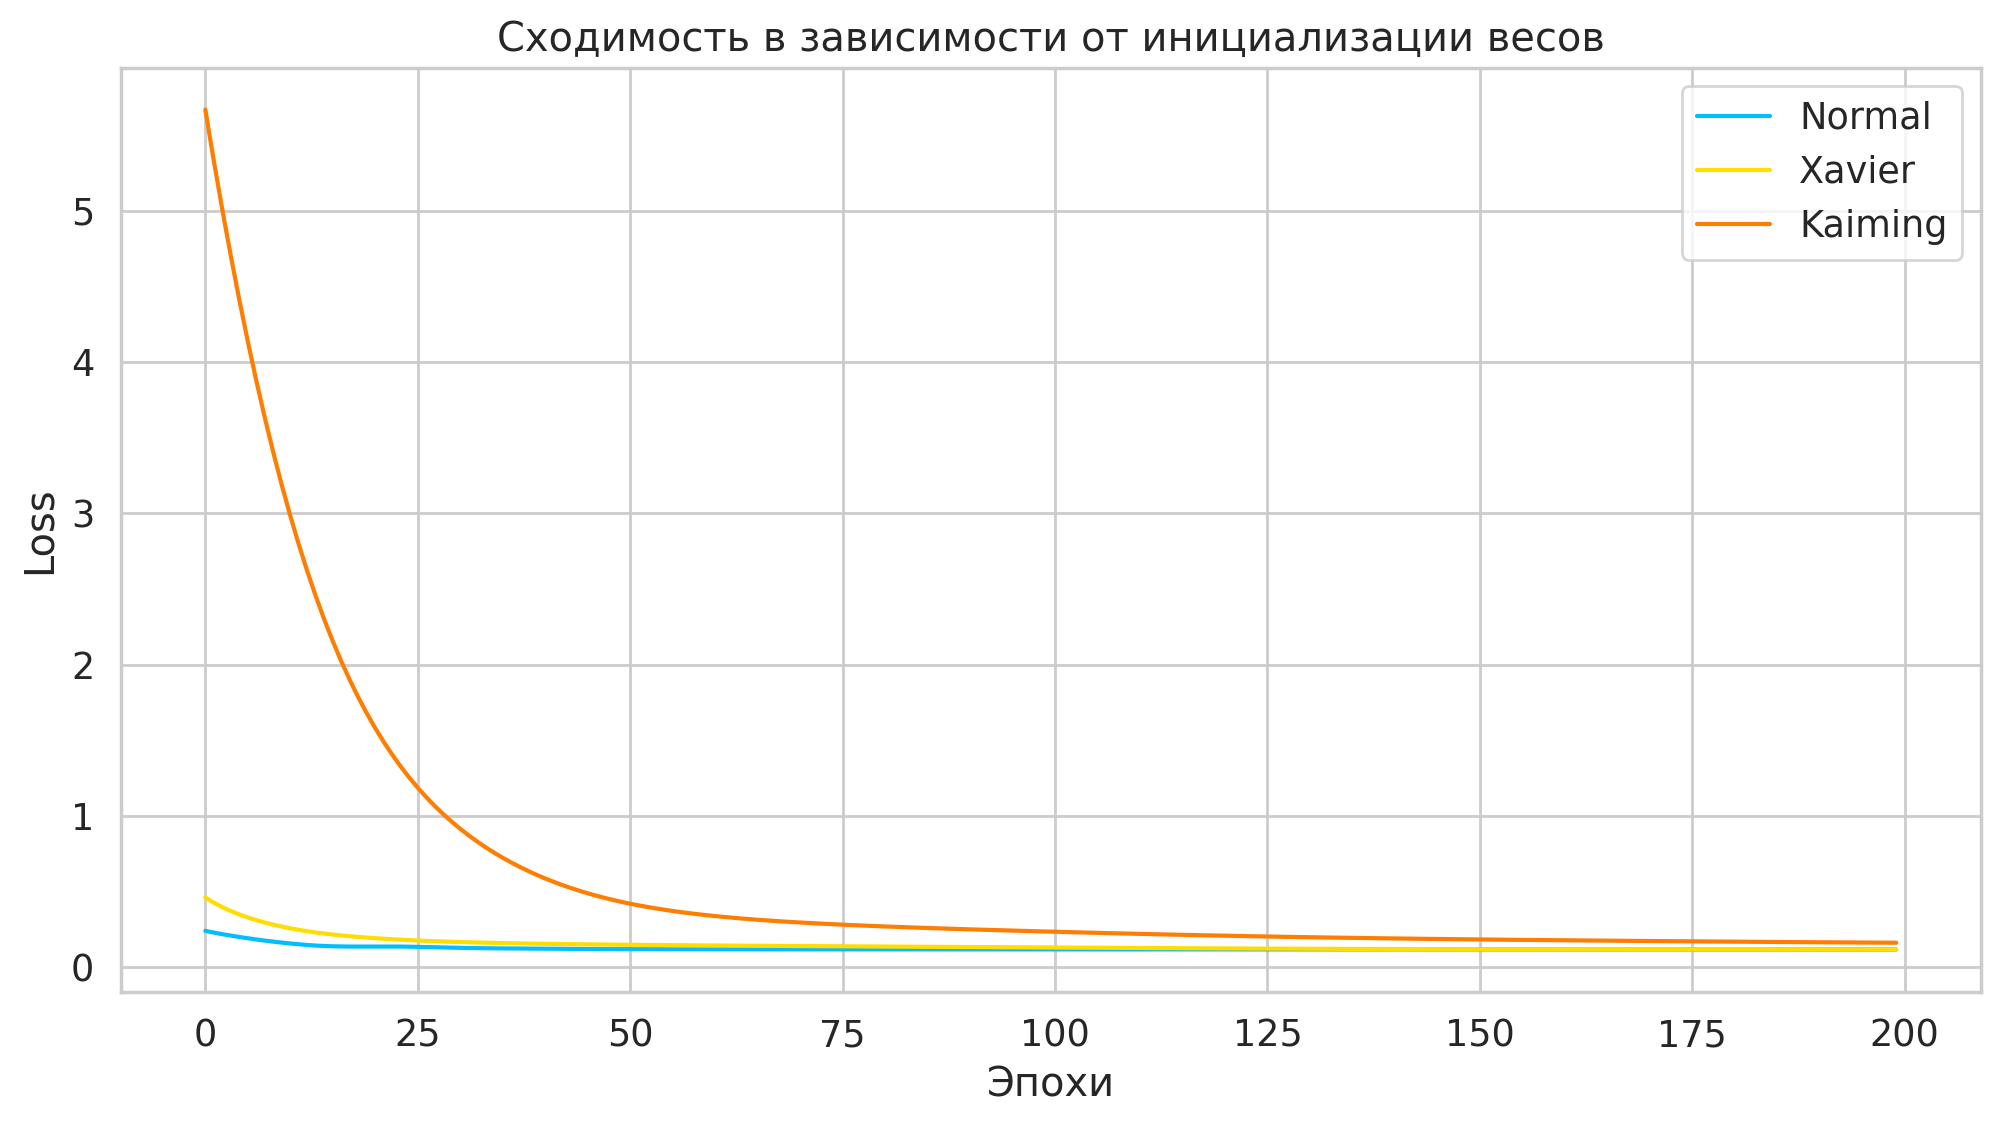

In [100]:
plt.figure(figsize=(12, 6))
for name, loss in results_initializations.items():
    plt.plot(loss, label=f"{name}")
plt.title("Сходимость в зависимости от инициализации весов")
plt.xlabel('Эпохи')
plt.ylabel('Loss')
plt.legend()
plt.show()


- ReLU или Leaky ReLU: Kaiming.
- Tanh или Sigmoid: Xavier.
- Простая сеть или для тестирования: Normal.

Важно помнить, что для очень глубоких сетей или с большим количеством параметров важно проводить эксперименты с различными инициализациями, поскольку каждая задача и архитектура могут требовать своего подхода.